In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List, Dict, Annotated
from operator import add
from IPython.display import Image, display

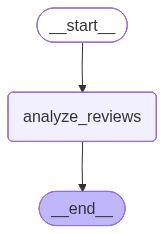

In [2]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class ProductReview(TypedDict):
    id: str
    product_name: str
    review_text: str
    rating: int

class ReviewState(TypedDict):
    raw_reviews: List[ProductReview]
    quality_score: float
    categorized_reviews: List[str]

class ReviewOutput(TypedDict):
    quality_score: float
    categorized_reviews: List[str]

def analyze_reviews(state):
    reviews = state["raw_reviews"]
    
    # Calculate average rating as quality score
    total_rating = sum(review["rating"] for review in reviews)
    quality_score = total_rating / len(reviews) if reviews else 0.0
    
    # Categorize reviews based on rating
    categorized = []
    for review in reviews:
        if review["rating"] >= 4:
            category = "Excellent"
        elif review["rating"] == 3:
            category = "Average"
        else:
            category = "Needs Improvement"
        
        categorized.append(f"{review['product_name']}-{category}-{review['id']}")
    
    return {
        "quality_score": round(quality_score, 2),
        "categorized_reviews": categorized
    }

# Build the graph
review_builder = StateGraph(ReviewState, output_schema=ReviewOutput)
review_builder.add_node("analyze_reviews", analyze_reviews)
review_builder.add_edge(START, "analyze_reviews")
review_builder.add_edge("analyze_reviews", END)

review_graph = review_builder.compile()

# Visualize the graph
display(Image(review_graph.get_graph().draw_mermaid_png()))

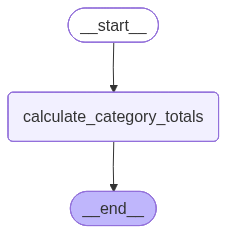

In [3]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class SalesRecord(TypedDict):
    id: str
    category: str
    amount: float
    region: str

class SalesState(TypedDict):
    sales_data: List[SalesRecord]
    category_totals: Dict[str, float]
    processed_records: List[str]

class SalesOutput(TypedDict):
    category_totals: Dict[str, float]
    processed_records: List[str]

def calculate_category_totals(state):
    records = state["sales_data"]
    category_sales = {}
    
    # Group sales by category and sum amounts
    for record in records:
        category_sales.setdefault(record["category"], []).append(record["amount"])
    
    # Calculate total sales per category
    totals = {cat: round(sum(amounts), 2) for cat, amounts in category_sales.items()}
    
    return {
        "category_totals": totals,
        "processed_records": [f"sales-{record['region']}-{record['id']}" for record in records]
    }

# Build the graph
sales_builder = StateGraph(SalesState, output_schema=SalesOutput)
sales_builder.add_node("calculate_category_totals", calculate_category_totals)
sales_builder.add_edge(START, "calculate_category_totals")
sales_builder.add_edge("calculate_category_totals", END)

sales_graph = sales_builder.compile()

# Visualize the graph
display(Image(sales_graph.get_graph().draw_mermaid_png()))

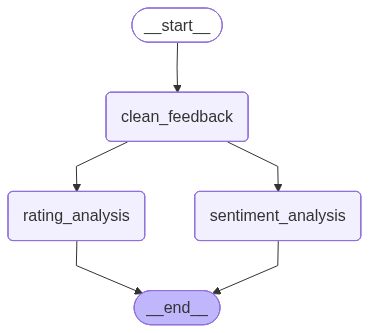

In [5]:
from typing import TypedDict, List, Dict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class FeedbackLog(TypedDict):
    id: str
    feedback_text: str
    rating: int
    category: str

class MainGraphState(TypedDict):
    raw_feedback: List[FeedbackLog]
    cleaned_logs: List[FeedbackLog]
    sentiment_summary: str
    average_ratings: Dict[str, float]
    processed_logs: List[str]

class MainGraphOutput(TypedDict):
    sentiment_summary: str
    average_ratings: Dict[str, float]
    processed_logs: List[str]

def clean_feedback(state):
    """Clean and validate feedback logs"""
    feedback = state["raw_feedback"]
    # Filter out empty feedback and validate data
    cleaned = [log for log in feedback if log.get("feedback_text", "").strip()]
    return {"cleaned_logs": cleaned}

def sentiment_analysis(state):
    """Analyze sentiment from cleaned feedback logs"""
    logs = state["cleaned_logs"]
    # Calculate sentiment summary based on ratings
    if not logs:
        return {"sentiment_summary": "No feedback to analyze"}
    
    avg_rating = sum(log["rating"] for log in logs) / len(logs)
    if avg_rating >= 4:
        sentiment = "Positive"
    elif avg_rating == 3:
        sentiment = "Neutral"
    else:
        sentiment = "Negative"
    
    return {
        "sentiment_summary": f"{sentiment} (avg rating: {round(avg_rating, 2)})"
    }

def rating_analysis(state):
    """Analyze ratings by category"""
    logs = state["cleaned_logs"]
    category_ratings = {}
    
    # Group ratings by category and calculate averages
    for log in logs:
        category = log["category"]
        category_ratings.setdefault(category, []).append(log["rating"])
    
    # Calculate average rating per category
    averages = {cat: round(sum(ratings) / len(ratings), 2) for cat, ratings in category_ratings.items()}
    
    processed = [f"feedback-{log['category']}-{log['id']}" for log in logs]
    
    return {
        "average_ratings": averages,
        "processed_logs": processed
    }

# Build the graph
main_builder = StateGraph(MainGraphState, output_schema=MainGraphOutput)

main_builder.add_node("clean_feedback", clean_feedback)
main_builder.add_node("sentiment_analysis", sentiment_analysis)
main_builder.add_node("rating_analysis", rating_analysis)

main_builder.add_edge(START, "clean_feedback")
main_builder.add_edge("clean_feedback", "sentiment_analysis")
main_builder.add_edge("clean_feedback", "rating_analysis")
main_builder.add_edge("sentiment_analysis", END)
main_builder.add_edge("rating_analysis", END)

main_graph = main_builder.compile()

# Visualize the graph
display(Image(main_graph.get_graph(xray=1).draw_mermaid_png()))


In [6]:
feedback_logs = [
    {
        "id": "1",
        "feedback_text": "Good explanation of topic",
        "rating": 5,
        "category": "Math"
    },
    {
        "id": "2",
        "feedback_text": "Could be better organized",
        "rating": 3,
        "category": "Science"
    },
    {
        "id": "3",
        "feedback_text": "Really good session!",
        "rating": 4,
        "category": "Math"
    }
]

# Run the graph
result = main_graph.invoke({"raw_feedback": feedback_logs})
print(result)

{'sentiment_summary': 'Positive (avg rating: 4.0)', 'average_ratings': {'Math': 4.5, 'Science': 3.0}, 'processed_logs': ['feedback-Math-1', 'feedback-Science-2', 'feedback-Math-3']}
